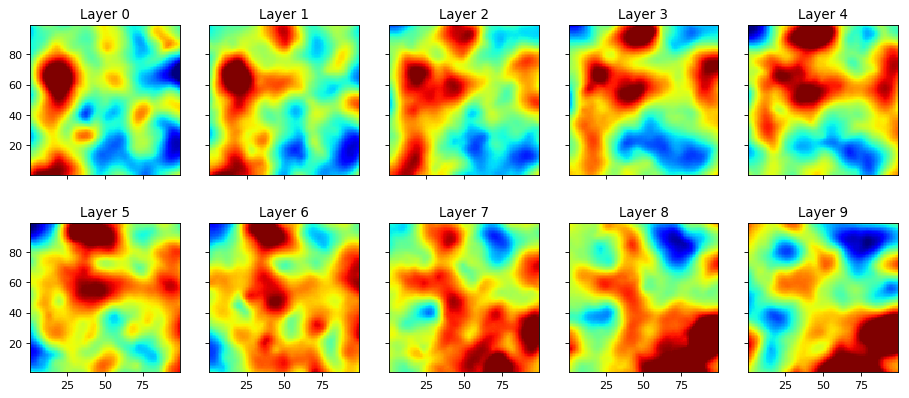

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np

# Input field name
field_name = 'field-100x100x10.csv'
mu     = -3  # Geometric mean
sigma2 = 4.5 # Variance

# Model domain and grid definition
Lx = 100.
Ly = 100.
Lz = 10.
ncol = 100
nrow = 100
nlay = 10
delr = Lx/ncol
delc = Ly/nrow
delv = Lz/nlay

# Load log-K field generated with SGEMS (mu = 0, sigma2 = 1)
y_field_01 = np.loadtxt(field_name, skiprows = 1).reshape((nlay, nrow, ncol))

# Rescale log-K field
y_field = mu + np.sqrt(sigma2) * y_field_01

# Visualize the 10 layers of the log-K field
fig, axs = plt.subplots(2, 5, sharex = True, sharey = True, figsize = (14, 6), dpi = 80)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
for layer, ax in enumerate(axs.flatten()):
    ax.imshow(y_field[layer, :, :], cmap = 'jet', extent = extent, origin = 'lower',
                      vmin = mu - 2*np.sqrt(sigma2), vmax = mu + 2*np.sqrt(sigma2))
    ax.set_title('Layer {}'.format(layer))

In [2]:
import flopy

# NOTE: update this variable with the path to MODFLOW executable
modflow_exe = '../bin/mf2005dbl'

# Hydraulic head difference along the x-direction
delta_h = 10

# Name of the ftl output file
outftl_name  = 'model.ftl'

# Init flopy
model_name = "example2"
model_ws = "tmp"

mf = flopy.modflow.Modflow(model_name, model_ws = model_ws, exe_name = modflow_exe)


ztop = 0.
zbot = np.zeros((nlay, nrow, ncol))
for i in range(nlay):
    zbot[i, :, :] = ztop - delv*(i+1)


dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr = delr, delc = delc,
                           top = ztop, botm = zbot, perlen = 1)

# Variables for the BAS package
ibound = np.ones((nlay, nrow, ncol), dtype = np.int32)
ibound[:, :,  0] = -1
ibound[:, :, -1] = -1

strt = np.zeros((nlay, nrow, ncol), dtype = np.float32)
for i in range(nlay):
    for j in range(nrow):
        strt[i, j, :] = np.linspace(delta_h, 0, num = ncol)

bas = flopy.modflow.ModflowBas(mf, ibound = ibound, strt = strt)

# Add LPF package to the MODFLOW model
lpf = flopy.modflow.ModflowLpf(mf, hk = np.exp(y_field), vka = 1.)

# Add OC package to the MODFLOW model
oc = flopy.modflow.ModflowOc(mf)

# Add PCG package to the MODFLOW model
pcg = flopy.modflow.ModflowPcg(mf, mxiter = 500, iter1 = 300)

# Add LMT package to the MODFLOW model
lmt = flopy.modflow.ModflowLmt(mf, output_file_header = 'extended',
                                   output_file_format = 'formatted',
                                   output_file_name = outftl_name)

# Write the MODFLOW model input files
mf.write_input()

# Run the MODFLOW model
success, buff = mf.run_model()

if not success:
    print('FLOW SIMULATION ERROR, SOMETHING WENT WRONG!')

FloPy is using the following  executable to run the model: ../bin/mf2005dbl.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: example2.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/02/21 15:10:14

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/02/21 15:10:16
 Elapsed run time:  2.095 Seconds

  Normal termination of simulation


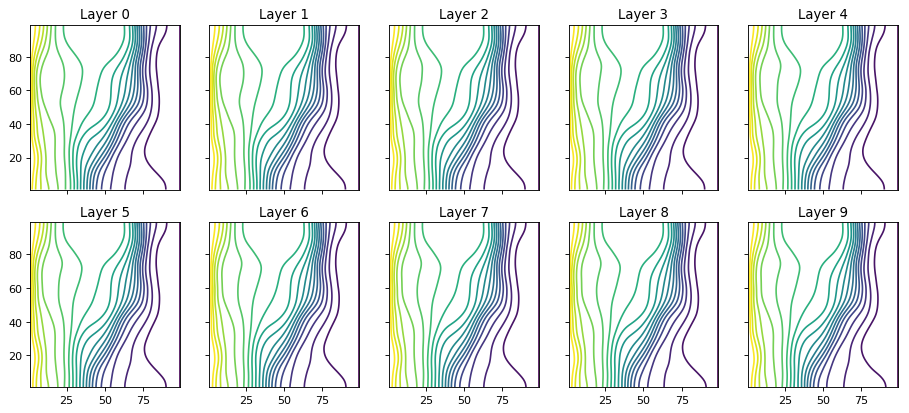

In [3]:
import flopy.utils.binaryfile as bf

fig, axs = plt.subplots(2, 5, sharex = True, sharey = True, figsize = (14, 6), dpi = 80)
extent = (delr/2., Lx - delr/2., delc/2., Ly - delc/2.)
levels = np.arange(0, delta_h, 0.5)
hds = bf.HeadFile('{}/{}.hds'.format(model_ws, model_name))
head = hds.get_data(totim = 1.0)
for layer, ax in enumerate(axs.flatten()):
    ax.contour(head[layer, :, :], levels = levels, extent = extent, origin = 'lower')
    ax.set_title('Layer {}'.format(layer))

In [4]:
import yaml
import os
import subprocess

from subprocess import call

# NOTE: update this variable with the path to PAR2 executable
par2_exe = '../../Build/Release/par2.exe'

# YAML Configuration file, particle tracking parameters can be modified here
config_file = 'config.yaml'

# Print the parameters in the configuration file
with open(config_file, 'r') as stream:
    try:
        params = yaml.load(stream)
        print(yaml.dump(params))
    except yaml.YAMLError as exc:
        print(exc)
        
# Create the output directory
if not os.path.exists('output'):
    os.mkdir('output')

print()

# Run PAR2
print('STARTING SIMULATION...')
proc = subprocess.run([par2_exe, config_file], capture_output = True, text = True)
print('DONE - RETURN CODE', proc.returncode)
# TODO show par2 console output in jupyter

grid:
  cell size: [1.0, 1.0, 1.0]
  dimension: [100, 100, 10]
output:
  csv:
    file: output/result.csv
    items:
    - {label: cbtx x=50, type: after-x, x: 50}
    - label: Inside box
      p1: [50, 20, 2]
      p2: [70, 80, 8]
      type: box
    skip: 10
  snapshot:
    file: output/snap-*.csv
    steps: [0, 500, 1000]
physics:
  longitudinal dispersivity: 0.01
  molecular diffusion: 1.0e-09
  porosity: 0.25
  transverse dispersivity: 0.001
  velocity: {file: tmp/model.ftl, type: modflow}
simulation:
  dt: 0.25
  particles:
    N: 100000
    start:
      p1: [5, 49, 4.9]
      p2: [7, 51, 5.1]
  steps: 1000


STARTING SIMULATION...
DONE - RETURN CODE 0


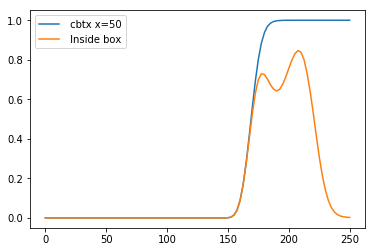

In [5]:
output_csv = 'output/result.csv'

with open(output_csv, 'r') as instream:
    labels = instream.readline()[:-1].split(',')
    data = np.loadtxt(instream, delimiter = ',')

ID_STEP = 0
ID_TIME = 1
    
plt.figure()
for i in range(2, len(labels)):
    plt.plot(data[:, ID_TIME], data[:, i], label = labels[i])
    
plt.legend()

(0, 100.0)

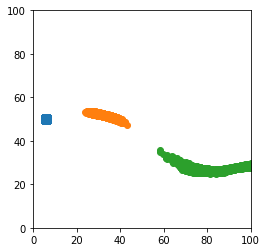

In [6]:
output_snap = 'output/snap-{}.csv'

steps = [0, 500, 1000]

plt.figure()
for step in steps:
    positions = np.loadtxt(output_snap.format(step), skiprows = 1, delimiter = ',')
    plt.plot(positions[:, 1], positions[:, 2], 'o')

plt.axis('scaled')
plt.xlim([0, Lx])
plt.ylim([0, Ly])